In [1]:
## Save future files to your drive
## In this notebook control for multiple testing
import numpy as np
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
%cd "/content/drive/My Drive/DQN"

Mounted at /content/drive
/content/drive/My Drive/DQN


In [2]:
pip install iisignature

     |████████████████████████████████| 1.3MB 2.8MB/s 
  Created wheel for iisignature: filename=iisignature-0.24-cp36-cp36m-linux_x86_64.whl size=2527483 sha256=b26b8b6824bfc7247d641d5b9f89c7edbe55da1ce4a081aeb1ea9ac02eff219a
  Stored in directory: /root/.cache/pip/wheels/57/33/98/2b03151aa0378df847a71a66ab6ed8f7594d310e11dcd60ed7
Successfully built iisignature


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import iisignature
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
# Generate traning and testing data based on the synthetic model 
def generate_data(t,T): # There are two arguements as the input, 
                        # The first one t is the length of the training data, the second one T is the length of the testing data
  np.random.seed(0)     # Fix the random seed so that we can fix the traing data to be the same
  b = np.zeros((t), float) 
  p = np.zeros((t), float)  
  b[0] = 0 
  p[0] = 0
  for i in range(t-1):
    p[i+1] = p[i] + b[i] + 3 * np.random.randn()
    b[i+1] = 0.9 * b[i] + np.random.randn()
  R = np.max(p) - np.min(p) # Fix the value of R, and use this to generate the testing data
  z1 = np.exp(p/R)

  b1 = np.zeros((T-t), float) 
  p1 = np.zeros((T-t), float)  
  b1[0] = b[t-1]
  p1[0] = p[t-1]
  np.random.seed()
  for i in range(T-t-1):
    #np.random.seed()
    p1[i+1] = p1[i] + b1[i] + 3 * np.random.randn()
    b1[i+1] = 0.9 * b1[i] + np.random.randn()
  z2 = np.exp(p1/R)
  return z1, z2       # There are two outputs, z1 represents the training data, and z2 represents the testing data

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Restoring parameters from Model/model.ckpt


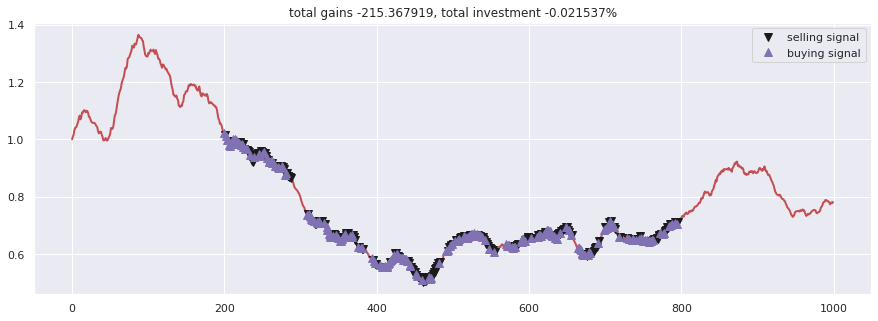

In [6]:
# Restore the best model and do the test on the fixed training data set
from stock_env_zero import stock
from test import test_DeepQNetwork

def run():
    observation = env.reset()
    observation, done = game_step(observation)   # 输入当前状态，调用game_step函数，选取动作，环境根据行为给出下一个 state, reward, 是否终止

def game_step(observation, step=None, train=True):
    # RL choose action based on observation DQN 根据观测值选择行为
    action = RL.choose_action(observation, train)
    # RL take action and get next observation and reward  环境根据行为给出下一个 state, reward, 是否终止
    observation_, reward, done = env.step(action)
    # DQN 存储记忆
    RL.store_transition(observation, action, reward, observation_)
    # print("total profit:%.3f" % env.total_profit, end='\r')
    # 控制学习起始时间和频率 (先累积一些记忆再开始学习)

    # swap observation 将下一个 state_ 变为 下次循环的 state
    observation = observation_
    return observation, done

def BackTest(env):
    observation = env.reset()
    step =0
    while True:
        observation, done = game_step(observation, train=False)
        # break while loop when end of this episode
        if done:
            break
    # print('total_profit:%.3f' % (env.total_profit))
    return env


if __name__ == "__main__":
    df = generate_data(1000, 10000)[0]
    df = pd.Series(df)
    trend = df.values.tolist()  # 选取收盘数据做测试
    env = stock(trend[0:1000])
    #调用模型，加载网络参数
    RL = test_DeepQNetwork(env.n_actions, env.n_features,
                      learning_rate=0.001,
                      reward_decay=0.99,
                      e_greedy=0.9,
                      replace_target_iter=200,
                      batch_size=200,
                      memory_size=4000,
                      )
    name ='lr=0.001, gamma=0.99, bs=200, ms=4000'
    #从加载到的模型中读取训练参数
    run()
    env = BackTest(env)
    env.draw(name)


In [7]:
# Define the function to calculate sharpe ratio 
def sharpe_ratio(daily_return):
  dql_sharpe_ratio = []
  for i in range(len(daily_return)-1):
    dql_sharpe_ratio.append((daily_return[i+1]-daily_return[i])/daily_return[i])
  dql_sharpe_ratio=np.array(dql_sharpe_ratio)
  mean_return=dql_sharpe_ratio.mean()
  std_return=dql_sharpe_ratio.std()
  sharpe_ratio=mean_return/std_return*np.sqrt(252)
  return sharpe_ratio

In [8]:
# Define the function to calculate maximum drwadown 
def MaxDrawdown(return_list):
    '''最大回撤率'''
    i = np.argmax((np.maximum.accumulate(return_list) - return_list) / np.maximum.accumulate(return_list))  # 结束位置
    if i == 0:
        return 0
    j = np.argmax(return_list[:i])  # 开始位置
    max_drawdown= (return_list[j] - return_list[i]) / (return_list[j])*100
    #plt.plot(return_list)
    #plt.plot([i, j], [return_list[i], return_list[j]], 'o', color="r", markersize=10)
    #plt.title('sharpe ratio %f,  maximum drawdown %f%%' %(sharpe_ratio(daily_return), max_drawdown ))
    #plt.legend()
    #plt.savefig('output-'+name+'-trade.png')
    #plt.show()
    return max_drawdown

-1.5444224325394906
2.846574910134089


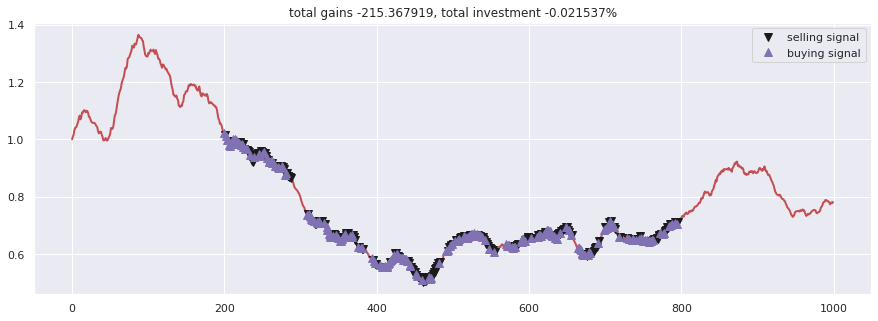

In [9]:
# Use the best model to do the test on the fixed traning set
df = generate_data(1000 ,10000)[0]
df = pd.Series(df)
test = df.values.tolist()
env = stock(test)
env = BackTest(env)
name ='lr=0.001, gamma=0.99, bs=200, ms=4000'
env.draw(name)
daily_return=env.get_info()[4] 
print (sharpe_ratio(daily_return))
print (MaxDrawdown(daily_return))

-0.02456298229409177
9.022659126989671


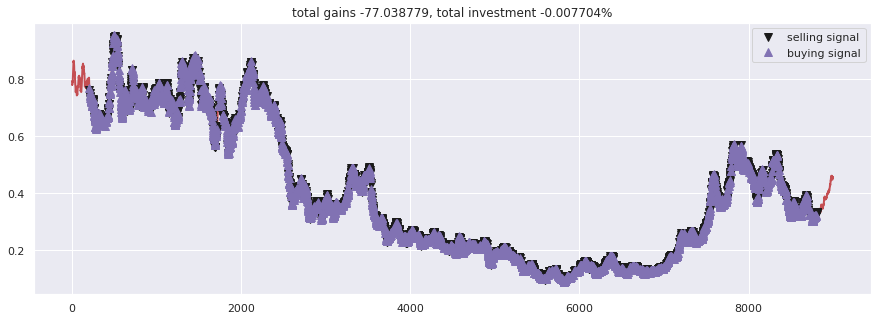

In [10]:
# Use the best model to do the test on one generated test data set
df = generate_data(1000 ,10000)[1]
df = pd.Series(df)
test = df.values.tolist()
env = stock(test)
env = BackTest(env)
name ='lr=0.001, gamma=0.99, bs=200, ms=4000'
env.draw(name)
daily_return=env.get_info()[4] 
print (sharpe_ratio(daily_return))
print (MaxDrawdown(daily_return))

In [ ]:
# Use the best model to do test on multiple samples based on the synthetic model 
# And calculate the test metrics
SP=[]
MD=[]
for i in range (100):
  df=pd.Series(generate_data(1000,10000)[1])
  test = df.values.tolist()
  env = stock(test[0:9000])
  env = BackTest(env)
  daily_return = env.get_info()[4]
  SP.append(sharpe_ratio(daily_return))
  MD.append(MaxDrawdown(daily_return))
SP=np.array(SP)
MD=np.array(MD)
#print(SP)
#print(MD)
mean_SP = SP.mean()
std_SP  = SP.std()
mean_MD = MD.mean()
std_MD  = MD.std()
print(mean_SP, std_SP)
print(mean_MD, std_MD)

#Moving Average Agent - zero transaction fee


In [ ]:
#file_path = '000065.SZ_NormalData.csv'
#df_= pd.read_csv(file_path)
#df=df_['close'][0:1500]
name = 'Moving Average Agent'
def signals(df):
  short_window = int(0.025 * len(df))
  long_window = int(0.05 * len(df))
  df=df.reset_index(drop=True)
  signals = pd.DataFrame(index=df.index) #定义新的signals dataframe，其中index与我们导入的数据一样
  #signals #接下来要一列一列进行扩充signals
  signals['signal'] = 0.0 
  signals['short_ma'] = df.rolling(window=20, min_periods=1, center=False).mean()
  signals['long_ma'] = df.rolling(window=100, min_periods=1, center=False).mean()
  signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:] > signals['long_ma'][short_window:], 1.0, 0.0)   
  signals['positions'] = signals['signal'].diff()
  return signals
#signals(df)[0:228]

In [ ]:
def buy_stock(
    real_movement,
    signal,              #这里的signal是对应上面siganl的position一列，给出买入卖出的信号1、-1
    initial_money = 10000,
    min_buy  = 100,
    min_sell = 100,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell       （1对应买，0代表卖）
    initial_money = 10000, ignore what kind of currency 
    max_buy = max quantity for share to buy   （购买的最大数量）
    max_sell = max quantity for share to sell （卖出的最大数量）
    """
    starting_money = initial_money
    market_value = 0
    stock_value = 0 
    states_sell = []
    states_buy = []
    daily_return = []
    current_inventory = 0 #现有库存
    #buy_rate = 0.0003  # 买入费率
    #buy_min = 5   # 最小买入费率
    #sell_rate = 0.0003  # 卖出费率
    #sell_min = 5  # 最大买入费率
    #stamp_duty = 0.001  # 印花税

    def buy(i, initial_money, current_inventory): 
        #shares = initial_money // real_movement[i]     #若剩余的initial money不够，则不能买入，//代表先做除法，再取floor，返回类型为float
        #if shares < 1:
        #    print(
        #        'day %d: total balances %f, not enough money to buy a unit price %f'
        #        % (i, initial_money, real_movement[i]) #%用于格式化字符串，这里real_movements代表实际价格
        #    )
        #else: #这里情况是可买股数大于等于1
        #    if shares > min_buy:    #即shares>100，此时可以买入
        #        buy_units = min_buy #买的单位设为min_buy,100股=1手
        #    else:                   #或shares<100
        #        buy_units = shares  #买的单位仍为1  
        # 买入股票数量
        buy_units = min_buy

        # 计算手续费等
        tmp_money = real_movement[i] * buy_units #买入股票的总价格
        #service_change = tmp_money * buy_rate  #券商的佣金
        #if service_change < buy_min: #不足5元，则以5元收取
        #    service_change = buy_min

        # 购买后，账户情况更新    
        initial_money = initial_money - tmp_money     #此时，initial_money代表剩余的金额=initial money-购买股票价格(手续费为0)
        current_inventory += buy_units                #现有的库存=原来的+增加的购买单位
        stock_value = current_inventory * real_movement[i]  # 持有股票总市值 = 现有的股票数量*买入当天股票价格
        #print(
        #        'day %d: buy %d units at price %f, total balance %f'
        #        % (i, buy_units, buy_units * real_movement[i], initial_money) 
        #    )
        states_buy.append(i)
        return initial_money, current_inventory           #buy函数返回的是，剩余的金额和现有库存

    def sell(i, initial_money, current_inventory):       
        # 卖出股票数量
        sell_units = min_sell 

        # 计算手续费等
        tmp_money = real_movement[i] * sell_units #卖出股票的总价格
        #service_change = tmp_money * sell_rate  #券商的佣金
        #if service_change < sell_min: #不足5元，则以5元收取
        #    service_change = sell_min
        #stamp = stamp_duty * tmp_money                 #印花税仅在卖出时收取，且=卖出股票的总价格*千分之一

        # 购买后，账户情况更新    
        initial_money = initial_money + tmp_money      #此时，initial_money代表剩余的金额=initial money+卖出股票价格
        current_inventory -= sell_units                #现有的库存=原来的+增加的购买单位
        stock_value = current_inventory * real_movement[i]  # 持有股票总市值 = 现有的股票数量*买入当天股票价格
        #print(
        #        'day %d: sell %d units at price %f, total balance %f'
        #        % (i, sell_units, sell_units * real_movement[i], initial_money) 
        #    )
        states_sell.append(i)
        return initial_money, current_inventory           #buy函数返回的是，剩余的金额和现有库存


    for i in range(real_movement.shape[0] - int(0.025 * len(df))):  #df.shape[0]=627- short window的长度15,这里的i代表着第几天，i=0不算因为为NAN 
        state = signal[i]                                           #state=signal[]这里是siganls['positions']，即代表了买入卖出的信号
        if state == 1 and initial_money >= real_movement[i]*100  :                                              #如果是买入信号，则余额和现有库存=对应 buy函数
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)                                    #并在states_buy中记录第几天进行买入操作
        elif state == -1 and current_inventory>0 :
            initial_money, current_inventory = sell(
                i, initial_money, current_inventory
            )                                                                             
        invest = ((initial_money - starting_money) / starting_money) * 100   #invest=（总的余额-刚开始的金额）/刚开始的金额 *100
        total_gains = initial_money - starting_money                        #即total profit=total gains=余额-刚开始的金额
        stock_value = current_inventory * real_movement[i]
        market_value = stock_value + initial_money
        daily_return.append(market_value) 
    return states_buy, states_sell, total_gains, invest, daily_return                 #返回买入的天数记录、卖出的天数记录、总获利、和获利比例

#Turtle Trading Agent - zero transaction fee

In [ ]:
#file_path = '000065.SZ_NormalData.csv'
#df_= pd.read_csv(file_path)
#df=df_['close'][0:1500]
#df=df.reset_index(drop=True)
#print(df)
name = 'Turtle Trading Agent'
#df.shape[0]
#int(0.025 * len(df))
#count = int(np.ceil(len(df) * 0.1))
def s(df):
  signals = pd.DataFrame(index=df.index)
  count = int(np.ceil(len(df) * 0.1)) #ceil函数取上整数，算出来count=32
  signals = pd.DataFrame(index=df.index)
  signals['signal'] = 0.0
  signals['trend'] = df
  signals['RollingMax'] = (signals.trend.shift(1).rolling(20).max()) #求前32个数中的最大值，并滚动
  signals['RollingMin'] = (signals.trend.shift(1).rolling(10).min()) #求前32个数中的最小值，并滚动
  signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = 1     #若股票值超过上轨，则为买入信号，设为1
  signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = -1      #若股票值低于下轨，则为卖出信号，设为-1
  return signals
#df = pd.Series(simulate_test_data(500))

In [ ]:
def buy_stock_t(
    real_movement,
    signal,              #这里的signal是对应上面siganl的position一列，给出买入卖出的信号1、-1
    initial_money = 10000,
    min_buy  = 100,
    min_sell = 100,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell       （1对应买，0代表卖）
    initial_money = 10000, ignore what kind of currency 
    max_buy = max quantity for share to buy   （购买的最大数量）
    max_sell = max quantity for share to sell （卖出的最大数量）
    """
    starting_money = initial_money
    market_value = 0
    stock_value = 0 
    states_sell = []
    states_buy = []
    daily_return = []
    current_inventory = 0 #现有库存
    #buy_rate = 0.0003  # 买入费率
    #buy_min = 5   # 最小买入费率
    #sell_rate = 0.0003  # 卖出费率
    #sell_min = 5  # 最大买入费率
    #stamp_duty = 0.001  # 印花税

    def buy(i, initial_money, current_inventory): 
        #shares = initial_money // real_movement[i]     #若剩余的initial money不够，则不能买入，//代表先做除法，再取floor，返回类型为float
        #if shares < 1:
        #    print(
        #        'day %d: total balances %f, not enough money to buy a unit price %f'
        #        % (i, initial_money, real_movement[i]) #%用于格式化字符串，这里real_movements代表实际价格
        #    )
        #else: #这里情况是可买股数大于等于1
        #    if shares > min_buy:    #即shares>100，此时可以买入
        #        buy_units = min_buy #买的单位设为min_buy,100股=1手
        #    else:                   #或shares<100
        #        buy_units = shares  #买的单位仍为1  
        # 买入股票数量
        buy_units = min_buy

        # 计算手续费等
        tmp_money = real_movement[i] * buy_units #买入股票的总价格
        #service_change = tmp_money * buy_rate  #券商的佣金
        #if service_change < buy_min: #不足5元，则以5元收取
        #    service_change = buy_min

        # 购买后，账户情况更新    
        initial_money = initial_money - tmp_money      #此时，initial_money代表剩余的金额=initial money-购买股票价格
        current_inventory += buy_units                #现有的库存=原来的+增加的购买单位
        stock_value = current_inventory * real_movement[i]  # 持有股票总市值 = 现有的股票数量*买入当天股票价格
        #print(
        #        'day %d: buy %d units at price %f, total balance %f'
        #        % (i, buy_units, buy_units * real_movement[i], initial_money) 
        #    )
        states_buy.append(i)
        return initial_money, current_inventory           #buy函数返回的是，剩余的金额和现有库存

    def sell(i, initial_money, current_inventory):       
        # 卖出股票数量
        sell_units = min_sell 

        # 计算手续费等
        tmp_money = real_movement[i] * sell_units #卖出股票的总价格
        #service_change = tmp_money * sell_rate  #券商的佣金
        #if service_change < sell_min: #不足5元，则以5元收取
        #    service_change = sell_min
        #stamp = stamp_duty * tmp_money                 #印花税仅在卖出时收取，且=卖出股票的总价格*千分之一

        # 购买后，账户情况更新    
        initial_money = initial_money + tmp_money      #此时，initial_money代表剩余的金额=initial money+购买股票价格
        current_inventory -= sell_units                #现有的库存=原来的+增加的购买单位
        stock_value = current_inventory * real_movement[i]  # 持有股票总市值 = 现有的股票数量*买入当天股票价格
        #print(
        #        'day %d: sell %d units at price %f, total balance %f'
        #        % (i, sell_units, sell_units * real_movement[i], initial_money) 
        #    )
        states_sell.append(i)
        return initial_money, current_inventory           #buy函数返回的是，剩余的金额和现有库存


    for i in range(real_movement.shape[0] - int(0.025 * len(df))):  #df.shape[0]=627- short window的长度15,这里的i代表着第几天，i=0不算因为为NAN 
        state = signal[i]                                           #state=signal[]这里是siganls['positions']，即代表了买入卖出的信号
        if state == 1 and initial_money >= real_movement[i]*100  :                                              #如果是买入信号，则余额和现有库存=对应 buy函数
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)                                    #并在states_buy中记录第几天进行买入操作
        elif state == -1 and current_inventory>0 :
            initial_money, current_inventory = sell(
                i, initial_money, current_inventory
            )                                                                             
        invest = ((initial_money - starting_money) / starting_money) * 100   #invest=（总的余额-刚开始的金额）/刚开始的金额 *100
        total_gains = initial_money - starting_money                        #即total profit=total gains=余额-刚开始的金额
        stock_value = current_inventory * real_movement[i]
        market_value = stock_value + initial_money
        daily_return.append(market_value) 
    return states_buy, states_sell, total_gains, invest, daily_return                 #返回买入的天数记录、卖出的天数记录、总获利、和获利比例

#Compare the performance of three different strategies in terms of the test matrics

In [ ]:
# compute mean_sp, std_sp, mean_md and std_md under the three different trading strategies based on the same multiple testing samples.
SP_ma=[]
MD_ma=[]
SP_t=[]
MD_t=[]
SP_dql=[]
MD_dql=[]
for i in range (100):
  df=pd.Series(generate_data(1000,10000)[1])
  test = df.values.tolist()
  env = stock(test[0:9000])
  env = BackTest(env)
  daily_return_ma  = buy_stock(df, signals(df)['positions'])[4]
  daily_return_t   = buy_stock_t(df, s(df)['signal'])[4]
  daily_return_dql = env.get_info()[4]
  SP_ma.append(sharpe_ratio(daily_return_ma))
  MD_ma.append(MaxDrawdown(daily_return_ma))
  SP_t.append(sharpe_ratio(daily_return_t))
  MD_t.append(MaxDrawdown(daily_return_t))
  SP_dql.append(sharpe_ratio(daily_return_dql))
  MD_dql.append(MaxDrawdown(daily_return_dql))
SP_ma=np.array(SP_ma)
MD_ma=np.array(MD_ma)
SP_t=np.array(SP_t)
MD_t=np.array(MD_t)
SP_dql=np.array(SP_dql)
MD_dql=np.array(MD_dql)
#print(SP)
#print(MD)
#indicators of moving average agent
mean_SP_ma = SP_ma.mean()
std_SP_ma  = SP_ma.std()
mean_MD_ma = MD_ma.mean()
std_MD_ma  = MD_ma.std()
#indicators of turtle trade agent
mean_SP_t  = SP_t.mean()
std_SP_t   = SP_t.std()
mean_MD_t  = MD_t.mean()
std_MD_t   = MD_t.std()
#indicators of deep q learning agent
mean_SP_dql= SP_dql.mean()
std_SP_dql = SP_dql.std()
mean_MD_dql= MD_dql.mean()
std_MD_dql = MD_dql.std()
print(mean_SP_ma , std_SP_ma, mean_MD_ma, std_MD_ma)
print(mean_SP_t , std_SP_t, mean_MD_t, std_MD_t)
print(mean_SP_dql , std_SP_dql, mean_MD_dql, std_MD_dql)

0.6336827389916418 0.3603776937202692 1.648956029961782 2.847611961936685
0.5813167728154217 0.4405895991823163 27.2167673516066 7.456474894496957
0.13181816002613755 0.5092651182456222 79.4699490675256 11.93349895448559


In [ ]:
# Plot the boxplot in terms if the sharpe ratio
plt.figure(figsize=(10,5))            
plt.title('Boxplot of the sharpe ratio ',fontsize=20) 
labels='Moving-Average Agent','Turtle-Traing Agent','Deep Q-Learning Agent'
plt.boxplot([SP_ma, SP_t, SP_dql], notch = True , showmeans=True, labels = labels) #notch：是否是凹口的形式展现箱线图；
plt.legend()
plt.savefig('sharpe ratio')
plt.show()

In [ ]:
# Plot the boxplot in terms if the maximum drawdown
plt.figure(figsize=(10,5))            
plt.title('Boxplot of the maximum drawdown ',fontsize=20) 
labels='Moving-Average Agent','Turtle-Traing Agent','Deep Q-Learning Agent'
plt.boxplot([MD_ma, MD_t, MD_dql], notch = True , showmeans=True,labels = labels) #notch：是否是凹口的形式展现箱线图；
plt.legend()
plt.savefig('maximum drawdown')
plt.show()